In [71]:
import numpy as np
from tensorflow import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [72]:
np.random.seed(20)


In [73]:
import os, gdown
from scipy.io import loadmat

# e.g. store in /tmp or ../data
cache_dir = "/tmp/svhn_data"
os.makedirs(cache_dir, exist_ok=True)

gdown.download("https://drive.google.com/uc?id=1FSwCLJzPzL4ZmihRgjIkh3DImRwM0UHb",
               os.path.join(cache_dir, "train_32x32.mat"), quiet=False)
gdown.download("https://drive.google.com/uc?id=10E7i5m1HaGWZkte4P8WMouNoFj0dFHmv",
               os.path.join(cache_dir, "test_32x32.mat"), quiet=False)

train_raw = loadmat(os.path.join(cache_dir, "train_32x32.mat"))
test_raw  = loadmat(os.path.join(cache_dir, "test_32x32.mat"))


Downloading...
From (original): https://drive.google.com/uc?id=1FSwCLJzPzL4ZmihRgjIkh3DImRwM0UHb
From (redirected): https://drive.google.com/uc?id=1FSwCLJzPzL4ZmihRgjIkh3DImRwM0UHb&confirm=t&uuid=4e006c45-e09b-477d-a1b0-cda72b154622
To: /tmp/svhn_data/train_32x32.mat
100%|██████████| 182M/182M [00:01<00:00, 180MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=10E7i5m1HaGWZkte4P8WMouNoFj0dFHmv
From (redirected): https://drive.google.com/uc?id=10E7i5m1HaGWZkte4P8WMouNoFj0dFHmv&confirm=t&uuid=63517809-57b1-4083-b20c-64752cb94ae3
To: /tmp/svhn_data/test_32x32.mat
100%|██████████| 64.3M/64.3M [00:00<00:00, 129MB/s]


In [74]:
# Load images and labels

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [75]:
# Check the shape of the data

print(train_images.shape)
print(test_images.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [76]:
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


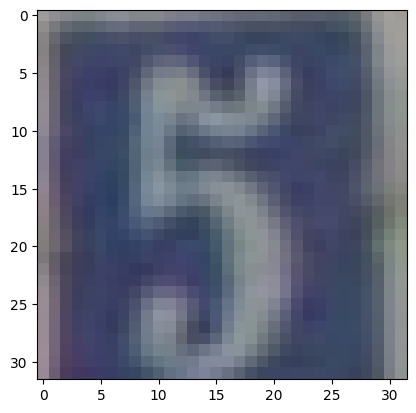

Label:  [5]


In [77]:
# Plot a random image and its label

plt.imshow(train_images[13529])
plt.show()

print('Label: ', train_labels[13529])

In [78]:
# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

In [79]:
# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [80]:
# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

Min: 0.0, Max: 255.0


In [81]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [82]:
# Split train data into train and validation sets

# Just try splitting the first 1000 samples for debugging
X_train, X_val, y_train, y_val = train_test_split(train_images[:1000], train_labels[:1000],
                                                  test_size=0.15, random_state=22)


In [83]:
y_val.shape

(150, 10)

In [84]:
# Data augmentation

datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [85]:
# Before training: set up a list + callback to log the LR
lrs = []

class LRTLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # grab the current learning rate from the optimizer and append it
        lr = float(keras.backend.get_value(self.model.optimizer.learning_rate))
        lrs.append(lr)

In [86]:
# Define auxillary model

keras.backend.clear_session()

aux_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

lr_schedule = keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = keras.optimizers.Adam(learning_rate=1e-4, amsgrad=True)
aux_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
# Fit model in order to determine best learning rate
lr_logger = LRTLogger()

history = aux_model.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=30, validation_data=(X_val, y_val),
                              callbacks=[lr_schedule, lr_logger])

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - accuracy: 0.1072 - loss: 3.6639 - val_accuracy: 0.2333 - val_loss: 2.2958 - learning_rate: 1.0000e-04
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - accuracy: 0.1151 - loss: 3.1120 - val_accuracy: 0.2400 - val_loss: 2.2915 - learning_rate: 1.2589e-04
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - accuracy: 0.1484 - loss: 2.6489 - val_accuracy: 0.2400 - val_loss: 2.2899 - learning_rate: 1.5849e-04
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - accuracy: 0.1550 - loss: 2.3920 - val_accuracy: 0.2400 - val_loss: 2.2808 - learning_rate: 1.9953e-04
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.1434 - loss: 2.3298 - val_accuracy: 0.2400 - val_loss: 2.2757 - learning_rate: 2.5119e-04
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - accuracy: 0.1490 - loss: 2.2932 - val_accuracy: 0.2400 - val_loss: 2.2718 - learning_rate: 3.1623e-04
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.1671 - loss:

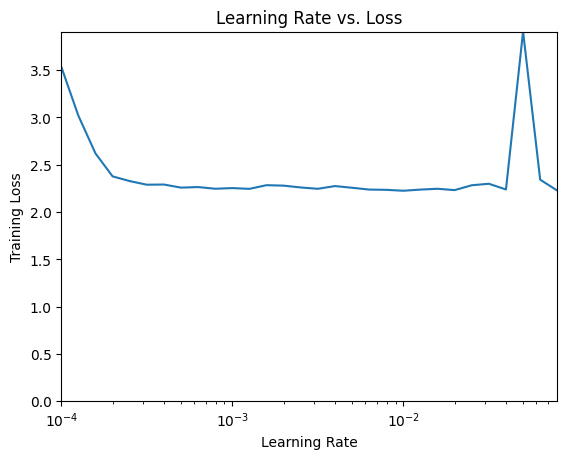

In [88]:
# Plot using the `lrs` list, not history.history['lr']
plt.semilogx(lrs, history.history['loss'])
plt.axis([min(lrs), max(lrs), 0, max(history.history['loss'])])
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.title('Learning Rate vs. Loss')
plt.show()

In [89]:
# Define actual model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
             "best_cnn.h5",
              save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [90]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,466 (2.10 MB)

 Trainable params: 551,018 (2.10 MB)

 Non-trainable params: 448 (1.75 KB)

In [91]:
# Fit model in order to make predictions

history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.1182 - loss: 3.7211

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - accuracy: 0.1203 - loss: 3.6682 - val_accuracy: 0.0733 - val_loss: 2.3028
Epoch 2/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.1076 - loss: 2.4161

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.1078 - loss: 2.4095 - val_accuracy: 0.1667 - val_loss: 2.3019
Epoch 3/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.1600 - loss: 2.3036

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - accuracy: 0.1610 - loss: 2.3040 - val_accuracy: 0.2400 - val_loss: 2.2983
Epoch 4/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.1661 - loss: 2.3020

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - accuracy: 0.1688 - loss: 2.3012 - val_accuracy: 0.2400 - val_loss: 2.2933
Epoch 5/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.1677 - loss: 2.2947

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - accuracy: 0.1707 - loss: 2.2936 - val_accuracy: 0.2400 - val_loss: 2.2892
Epoch 6/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.1838 - loss: 2.2867

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - accuracy: 0.1822 - loss: 2.2855 - val_accuracy: 0.2400 - val_loss: 2.2845
Epoch 7/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 366ms/step - accuracy: 0.1561 - loss: 2.2973 - val_accuracy: 0.2400 - val_loss: 2.2884
Epoch 8/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.1649 - loss: 2.2799

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - accuracy: 0.1655 - loss: 2.2791 - val_accuracy: 0.0667 - val_loss: 2.2829
Epoch 9/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.1697 - loss: 2.2873

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - accuracy: 0.1685 - loss: 2.2869 - val_accuracy: 0.2400 - val_loss: 2.2768
Epoch 10/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.1898 - loss: 2.2855

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.1914 - loss: 2.2844 - val_accuracy: 0.2400 - val_loss: 2.2731
Epoch 11/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.2039 - loss: 2.2542

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.2035 - loss: 2.2552 - val_accuracy: 0.2400 - val_loss: 2.2598
Epoch 12/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - accuracy: 0.1873 - loss: 2.2568 - val_accuracy: 0.2400 - val_loss: 2.2794
Epoch 13/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.1540 - loss: 2.2699 - val_accuracy: 0.2400 - val_loss: 2.2832
Epoch 14/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.1558 - loss: 2.2815 - val_accuracy: 0.2400 - val_loss: 2.2734
Epoch 15/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.1549 - loss: 2.2663 - val_accuracy: 0.2400 - val_loss: 2.2769
Epoch 16/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.1705 - loss: 2.2410 - val_accuracy: 0.2400 - val_loss: 2.2797
Epoch 17/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.1866 - loss: 2.2716 - val_accuracy: 0.2400 - val_loss: 2.2638
Epoch 18/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.1895 - loss: 2.2304

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.1882 - loss: 2.2319 - val_accuracy: 0.2400 - val_loss: 2.2498
Epoch 19/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.1823 - loss: 2.2470 - val_accuracy: 0.2400 - val_loss: 2.2670
Epoch 20/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - accuracy: 0.1845 - loss: 2.2165 - val_accuracy: 0.2400 - val_loss: 2.2563
Epoch 21/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.1806 - loss: 2.2389 - val_accuracy: 0.2400 - val_loss: 2.2741
Epoch 22/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - accuracy: 0.2085 - loss: 2.2216 - val_accuracy: 0.2400 - val_loss: 2.2569
Epoch 23/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.2002 - loss: 2.2238

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 0.1997 - loss: 2.2247 - val_accuracy: 0.2400 - val_loss: 2.2346
Epoch 24/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.1924 - loss: 2.2395

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.1935 - loss: 2.2389 - val_accuracy: 0.2400 - val_loss: 2.2267
Epoch 25/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - accuracy: 0.2078 - loss: 2.2009 - val_accuracy: 0.2400 - val_loss: 2.2655
Epoch 26/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.2006 - loss: 2.1982 - val_accuracy: 0.2400 - val_loss: 2.2477
Epoch 27/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.1869 - loss: 2.2226 - val_accuracy: 0.2400 - val_loss: 2.2455
Epoch 28/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.1732 - loss: 2.2099 - val_accuracy: 0.2400 - val_loss: 2.2319
Epoch 29/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.1942 - loss: 2.2160 - val_accuracy: 0.2400 - val_loss: 2.2455
Epoch 30/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.1926 - loss: 2.2031 - val_accuracy: 0.2400 - val_loss: 2.2425
Epoch 31/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.2147 - loss: 2.2027 - val_accuracy: 0.2400 - val_loss: 2.2

In [92]:
# Evaluate train and validation accuracies and losses

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

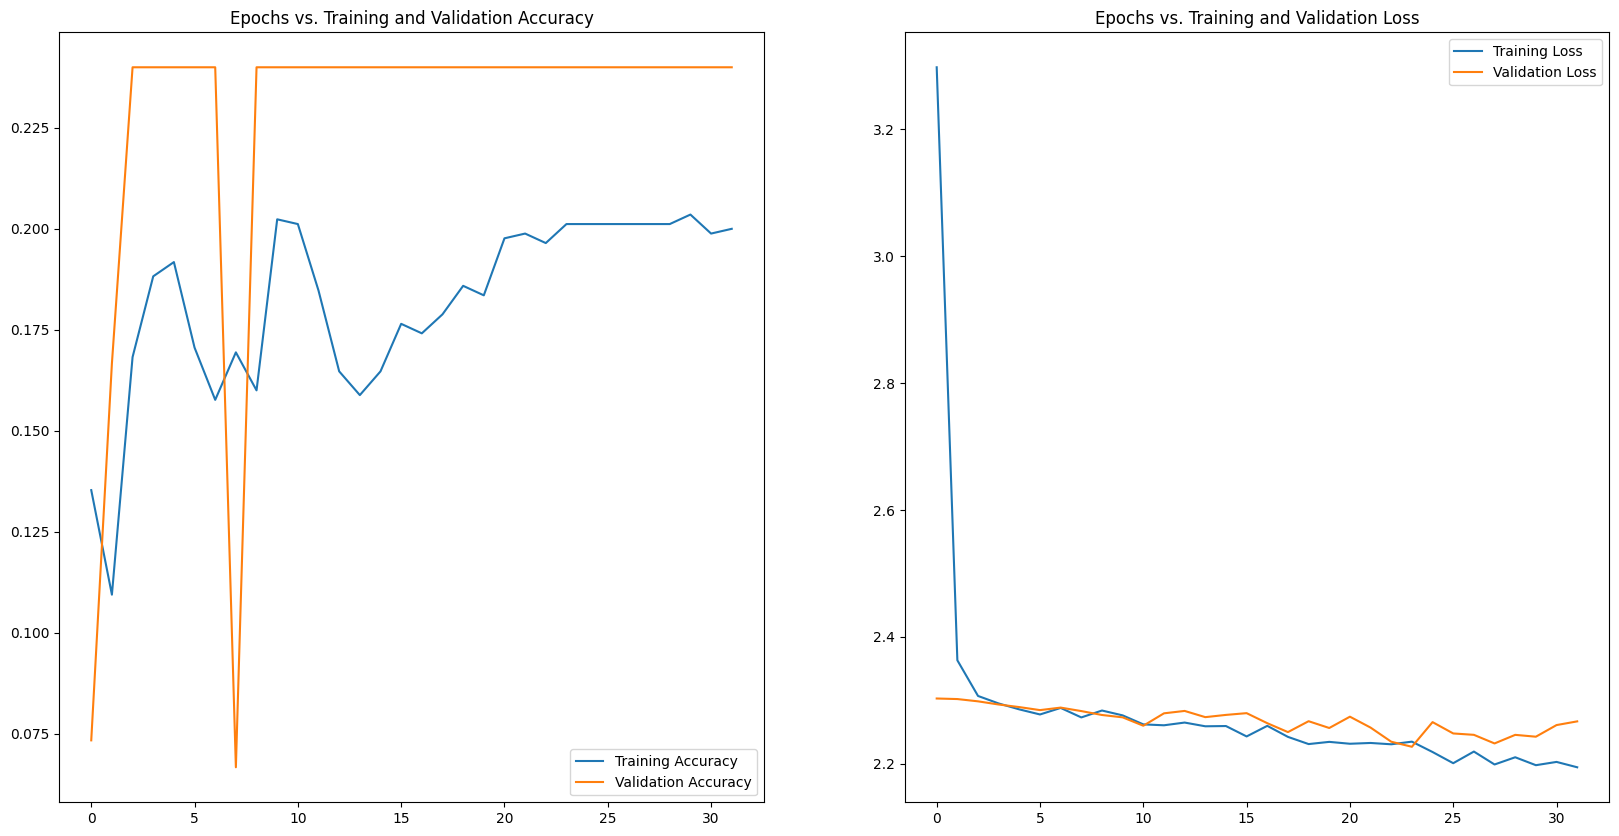

In [93]:
# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

In [94]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.1959 
Test loss is: 2.2686


In [95]:
# Get predictions and apply inverse transformation to the labels

y_pred = model.predict(X_train)

y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(y_train, lb.classes_)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


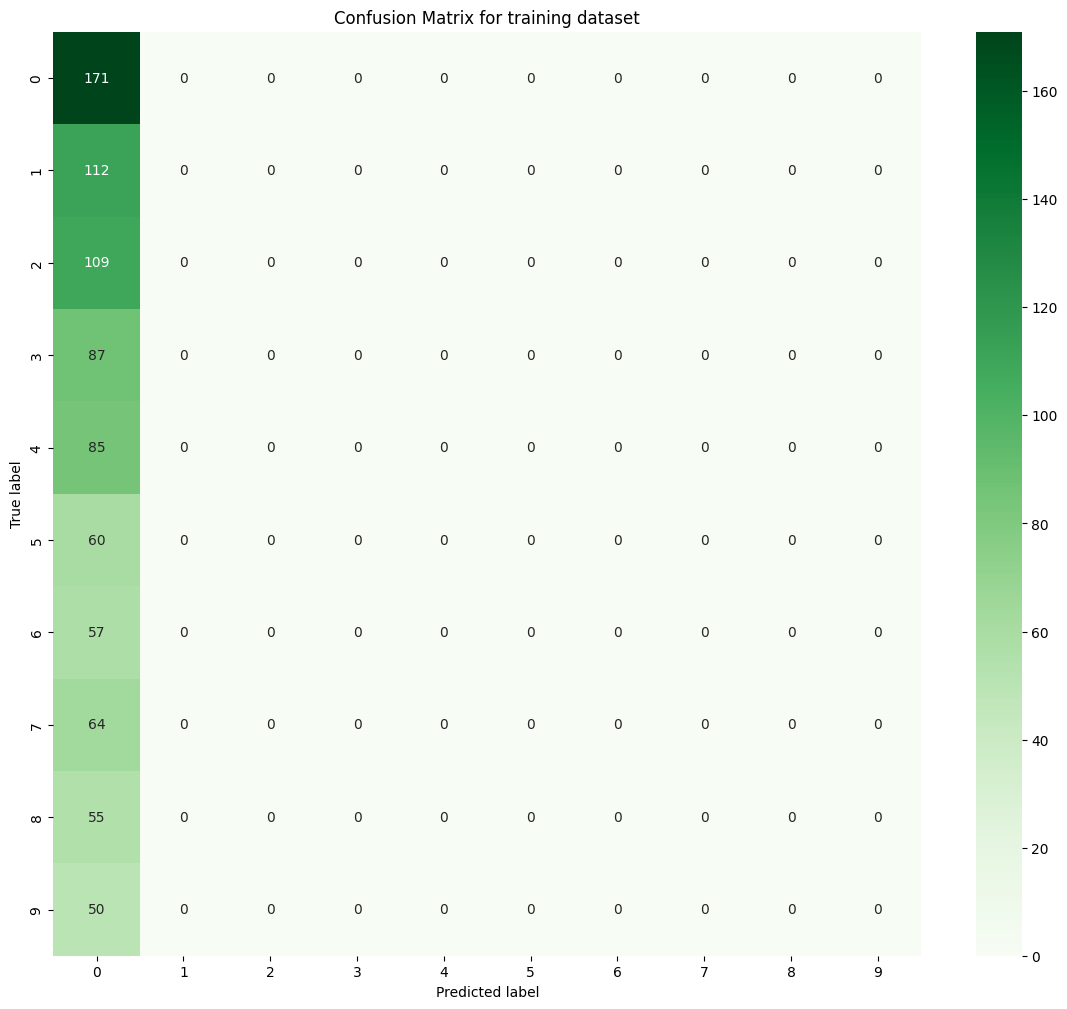

In [96]:
# Plot the confusion matrix

matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [97]:
# Ignore the errors in the plots

np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [101]:
# Define a model which gives the outputs of the layers
from tensorflow.keras.layers import Conv2D
from tensorflow import keras

# Option A: Programmatically grab all Conv2D layers
layers = [layer for layer in model.layers if isinstance(layer, Conv2D)]

# Now extract their outputs
layer_outputs = [layer.output for layer in layers]

# Build a new model that, given the original model’s input, returns these activations
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

AttributeError: The layer sequential has never been called and thus has no defined input.

In [ ]:
# Create a list with the names of the layers

layer_names = []
for layer in layers:
    layer_names.append(layer.name)

In [ ]:
# Define a function which will plot the convolutional filters

def plot_convolutional_filters(img):
    
    img = np.expand_dims(img, axis=0)
    activations = activation_model.predict(img)
    images_per_row = 9
    
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): 
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')

In [ ]:
img = X_train[42500]
plt.imshow(img)
plt.show()

In [ ]:
plot_convolutional_filters(img)
